In [1]:
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
from matplotlib import patches
import tensorflow as tf
from tensorflow.keras.models import load_model
from utils import *
from SISE import SISE as sise
import os
import xml.etree.ElementTree as ET
import time
import pandas as pd
from xplique.metrics import Deletion, Insertion

In [4]:
classese = {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13,
 'person': 14, 'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}
# classese = {'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}
label = tf.keras.utils.to_categorical(list(classese.values()), 20)


label_path = 'D:/dataset/PASCAL_VOC_2007/VOC2007/Annotations'
test_data_path = 'D:/dataset/PASCAL_VOC_2007/VOC2007/test'
img_name_list = []

for class_name, class_index in classese.items():
    print(class_name)
    for annotation in os.listdir(f'{test_data_path}/{class_name}'):
        img_name_list.append((class_name, annotation))


aeroplane
bicycle
bird
boat
bottle
bus
car
cat
chair
cow
diningtable
dog
horse
motorbike
person
pottedplant
sheep
sofa
train
tvmonitor


In [3]:
model = load_model('model/resnet152_voc2007')

In [4]:
test_data = '000801.jpg'
# AC-SISE
ac_sise = sise(model, 'resnet50', f'{test_data_path}/car/{test_data}', classese['car'], 0.5, 0)
ac_sise.feature_extractor()
ac_sise.feature_filtering()
ac_sise.filtering_zero_feature_maps()
ac_sise.postprocess()
# ac_sise.attribution_masks_compress()
ac_sise.new_attribution_masks_compress1(1)
ac_sise.generate_layer_visualization_map()
ac_sise.layers_fusion()

In [5]:
tree = ET.parse(f'{label_path}/{test_data.replace(".jpg", ".xml")}')
root = tree.getroot()
anno_bbox = get_label(root)
bbox = generate_bbox(normalization(ac_sise.result), 0.2)

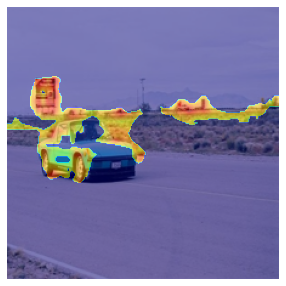

In [6]:
plt.figure(figsize=(5,5))
plt.imshow(ac_sise.img)
plt.imshow(normalization(ac_sise.result), cmap='jet', alpha=0.5)
# plt.colorbar()
# ax = plt.gca()
# rect1 = patches.Rectangle((anno_bbox['xmin'], anno_bbox['ymin']), anno_bbox['w'], anno_bbox['h'], linewidth=2, edgecolor='g', facecolor='none')
# rect2 = patches.Rectangle((bbox[1], bbox[0]), (bbox[3]-bbox[1]), (bbox[2]-bbox[0]), linewidth=2, edgecolor='r', facecolor='none')
# ax.add_patch(rect1)
# ax.add_patch(rect2)
plt.axis('off')
plt.show()

In [4]:
classese = {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13,
 'person': 14, 'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}

label_path = 'D:/dataset/PASCAL_VOC_2007/VOC2007/Annotations'
test_data_path = 'D:/dataset/PASCAL_VOC_2007/VOC2007/test'

In [26]:
# block = [4, 38, 80, 142, 174]
block = [4, 56, 152, 300, 464]
for i in block:
    print(model.layers[i].name)

conv1_relu
conv3_block2_2_relu
conv4_block3_out
conv4_block18_3_bn
conv4_block35_1_bn


In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

# ResNet152

# NEW AC-SISE1 (mask1 & mask2 / mask1)

In [10]:
ebpg_result = list()
iou_result = list()
elapsed_time_list = list()
total_reduction_rate_list = list()
deletion_result = list()
insertion_result = list()

index = 0

for class_name, class_index in classese.items():
    print(class_name)
    for annotation in os.listdir(f'{test_data_path}/{class_name}'):
        tree = ET.parse(f'{label_path}/{annotation.replace(".jpg", ".xml")}')
        root = tree.getroot()
        anno_bbox = get_label(root)

        ac_sise = sise(model, 'resnet50', f'{test_data_path}/{class_name}/{annotation}', class_index, 0.5, 0)
        ac_sise.feature_extractor()
        ac_sise.feature_filtering()
        ac_sise.filtering_zero_feature_maps()
        ac_sise.postprocess()
        ac_sise.new_attribution_masks_compress1(1)
        start = time.time()
        ac_sise.generate_layer_visualization_map()
        ac_sise.layers_fusion()
        end = time.time()
        
        # deletion_metric = Deletion(model, ac_sise.input_img, [label[classese[class_name]]])
        # insertion_metric = Insertion(model, ac_sise.input_img, [label[classese[class_name]]])
        # deletion_score = deletion_metric.evaluate(np.expand_dims(ac_sise.result, axis=0))
        # insertion_score = insertion_metric.evaluate(np.expand_dims(ac_sise.result, axis=0))

        # deletion_result.append(deletion_score)
        # insertion_result.append(insertion_score)
        ebpg_result.append(energy_point_game((round(anno_bbox['xmin']), round(anno_bbox['ymin']), round(anno_bbox['xmax']), round(anno_bbox['ymax'])), ac_sise.result))
        bbox = generate_bbox(normalization(ac_sise.result), 0.2)
        iou_result.append(IoU(bbox, (round(anno_bbox['ymin']), round(anno_bbox['xmin']), round(anno_bbox['ymax']), round(anno_bbox['xmax']))))
        elapsed_time_list.append(end-start)
        total_reduction_rate_list.append(ac_sise.total_reduction_rate)

        index+=1
        print(f'{index}/7013')

    df = pd.DataFrame({'ebpg result':ebpg_result, 'iou result':iou_result, 'deletion_result': deletion_result, 'insertion_result': insertion_result, 'elapsed time list':elapsed_time_list, 'total reduction rate list': total_reduction_rate_list})
    df.to_excel(excel_writer=f'./resnet152_result/NEW_AC_SISE1/NEW_AC_SISE1_resnet152_{class_name}_iou0.5.xlsx')

aeroplane
1/7013
2/7013
3/7013
4/7013
5/7013
6/7013
7/7013
8/7013
9/7013
10/7013
11/7013
12/7013
13/7013
14/7013
15/7013
16/7013
17/7013
18/7013
19/7013
20/7013
21/7013
22/7013
23/7013
24/7013
25/7013
26/7013
27/7013
28/7013
29/7013
30/7013
31/7013
32/7013
33/7013
34/7013
35/7013
36/7013
37/7013
38/7013
39/7013
40/7013
41/7013
42/7013
43/7013
44/7013
45/7013
46/7013
47/7013
48/7013
49/7013
50/7013
51/7013
52/7013
53/7013
54/7013
55/7013
56/7013
57/7013
58/7013
59/7013
60/7013
61/7013
62/7013
63/7013
64/7013
65/7013
66/7013
67/7013
68/7013
69/7013
70/7013
71/7013
72/7013
73/7013
74/7013
75/7013
76/7013
77/7013
78/7013
79/7013
80/7013
81/7013
82/7013
83/7013
84/7013
85/7013
86/7013
87/7013
88/7013
89/7013
90/7013
91/7013
92/7013
93/7013
94/7013
95/7013
96/7013
97/7013
98/7013
99/7013
100/7013
101/7013
102/7013
103/7013
104/7013
105/7013
106/7013
107/7013
108/7013
109/7013
110/7013
111/7013
112/7013
113/7013
114/7013
115/7013
116/7013
117/7013
118/7013
119/7013
120/7013
121/7013
122/7013


ValueError: All arrays must be of the same length

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(ac_sise.img)
plt.imshow(normalization(ac_sise.result), cmap='jet', alpha=0.5)
plt.colorbar()
ax = plt.gca()
rect1 = patches.Rectangle((anno_bbox['xmin'], anno_bbox['ymin']), anno_bbox['w'], anno_bbox['h'], linewidth=2, edgecolor='g', facecolor='none')
rect2 = patches.Rectangle((bbox[1], bbox[0]), (bbox[3]-bbox[1]), (bbox[2]-bbox[0]), linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.show()

NameError: name 'ac_sise' is not defined

<Figure size 360x360 with 0 Axes>

In [ ]:
print('Mean EBPG:', sum(ebpg_result)/len(ebpg_result))
print('Mean IoU:', sum(iou_result)/len(iou_result))
print('Mean Deletion:', sum(deletion_result)/len(deletion_result))
print('Mean Insertion:', sum(insertion_result)/len(insertion_result))
print('Mean elapsed time:', sum(elapsed_time_list)/len(elapsed_time_list))
print('Mean total reduction rate:', sum(total_reduction_rate_list)/len(total_reduction_rate_list))

Mean EBPG: 0.47204177397064767
Mean IoU: 0.08577271808175893
Mean elapsed time: 1.8688843319287878
Mean total reduction rate: -85.22033436732242


# NEW AC-SISE2 (mask1 & mask2 / mask1 | mask2)

In [10]:
ebpg_result = list()
iou_result = list()
elapsed_time_list = list()
total_reduction_rate_list = list()

index = 0

for class_name, class_index in classese.items():
    print(class_name)
    for annotation in os.listdir(f'{test_data_path}/{class_name}'):
        tree = ET.parse(f'{label_path}/{annotation.replace(".jpg", ".xml")}')
        root = tree.getroot()
        anno_bbox = get_label(root)

        ac_sise = sise(model, 'resnet50', f'{test_data_path}/{class_name}/{annotation}', class_index, 0.5, 0)
        ac_sise.feature_extractor()
        ac_sise.feature_filtering()
        ac_sise.filtering_zero_feature_maps()
        ac_sise.postprocess()
        ac_sise.new_attribution_masks_compress1(2)
        start = time.time()
        ac_sise.generate_layer_visualization_map()
        ac_sise.layers_fusion()
        end = time.time()
        
        ebpg_result.append(energy_point_game((round(anno_bbox['xmin']), round(anno_bbox['ymin']), round(anno_bbox['xmax']), round(anno_bbox['ymax'])), ac_sise.result))
        bbox = generate_bbox(normalization(ac_sise.result), 0.2)
        iou_result.append(IoU(bbox, (round(anno_bbox['ymin']), round(anno_bbox['xmin']), round(anno_bbox['ymax']), round(anno_bbox['xmax']))))
        elapsed_time_list.append(end-start)
        total_reduction_rate_list.append(ac_sise.total_reduction_rate)

        index+=1
        print(f'{index}/7013')

    df = pd.DataFrame({'ebpg result':ebpg_result, 'iou result':iou_result, 'elapsed time list':elapsed_time_list, 'total reduction rate list': total_reduction_rate_list})
    df.to_excel(excel_writer=f'./resnet50_result/NEW_AC_SISE2_0307/NEW_AC_SISE2_resnet50_{class_name}_0307_iou0.5.xlsx')

aeroplane
bicycle
bird
boat
bottle
bus
car
cat
chair
cow
diningtable
dog
horse
motorbike
person
pottedplant
sheep
sofa
train
tvmonitor


In [11]:
df = pd.DataFrame({'ebpg result':ebpg_result, 'iou result':iou_result, 'elapsed time list':elapsed_time_list, 'total reduction rate list': total_reduction_rate_list})
df.to_excel(excel_writer='NEW_AC_SISE2_resnet50_iou0.5.xlsx')

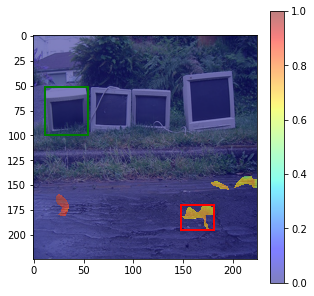

In [12]:
plt.figure(figsize=(5,5))
plt.imshow(ac_sise.img)
plt.imshow(normalization(ac_sise.result), cmap='jet', alpha=0.5)
plt.colorbar()
ax = plt.gca()
rect1 = patches.Rectangle((anno_bbox['xmin'], anno_bbox['ymin']), anno_bbox['w'], anno_bbox['h'], linewidth=2, edgecolor='g', facecolor='none')
rect2 = patches.Rectangle((bbox[1], bbox[0]), (bbox[3]-bbox[1]), (bbox[2]-bbox[0]), linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.show()

In [17]:
ebpg_result = list()
iou_result = list()
elapsed_time_list = list()
total_reduction_rate_list = list()

index = 0

for class_name, class_index in classese.items():
    print(class_name)
    for annotation in os.listdir(f'{test_data_path}/{class_name}'):
        tree = ET.parse(f'{label_path}/{annotation.replace(".jpg", ".xml")}')
        root = tree.getroot()
        anno_bbox = get_label(root)

        ac_sise = sise(model, 'resnet50', f'{test_data_path}/{class_name}/{annotation}', class_index, 0.5, 0)
        ac_sise.feature_extractor()
        ac_sise.feature_filtering()
        ac_sise.filtering_zero_feature_maps()
        ac_sise.postprocess()
        ac_sise.new_attribution_masks_compress2()
        start = time.time()
        ac_sise.generate_layer_visualization_map()
        ac_sise.layers_fusion()
        end = time.time()
        
        ebpg_result.append(energy_point_game((round(anno_bbox['xmin']), round(anno_bbox['ymin']), round(anno_bbox['xmax']), round(anno_bbox['ymax'])), ac_sise.result))
        bbox = generate_bbox(normalization(ac_sise.result), 0.2)
        iou_result.append(IoU(bbox, (round(anno_bbox['ymin']), round(anno_bbox['xmin']), round(anno_bbox['ymax']), round(anno_bbox['xmax']))))
        elapsed_time_list.append(end-start)
        total_reduction_rate_list.append(ac_sise.total_reduction_rate)
        index+=1
        print(f'{index}/7013')

    df = pd.DataFrame({'ebpg result':ebpg_result, 'iou result':iou_result, 'elapsed time list':elapsed_time_list, 'total reduction rate list': total_reduction_rate_list})
    df.to_excel(excel_writer=f'./resnet50_result/NEW_AC_SISE3_0310/NEW_AC_SISE3_resnet50_{class_name}_0307_iou0.5.xlsx')

aeroplane
1/7013
2/7013
3/7013
4/7013
5/7013
6/7013
7/7013
8/7013
9/7013
10/7013
11/7013
12/7013
13/7013
14/7013
15/7013
16/7013
17/7013
18/7013
19/7013
20/7013
21/7013
22/7013
23/7013
24/7013
25/7013
26/7013
27/7013
28/7013
29/7013
30/7013
31/7013
32/7013
33/7013
34/7013
35/7013
36/7013
37/7013
38/7013
39/7013
40/7013
41/7013
42/7013
43/7013
44/7013
45/7013
46/7013
47/7013
48/7013
49/7013
50/7013
51/7013
52/7013
53/7013
54/7013
55/7013
56/7013
57/7013
58/7013
59/7013
60/7013
61/7013
62/7013
63/7013
64/7013
65/7013
66/7013
67/7013
68/7013
69/7013
70/7013
71/7013
72/7013
73/7013
74/7013
75/7013
76/7013
77/7013
78/7013
79/7013
80/7013
81/7013
82/7013
83/7013
84/7013
85/7013
86/7013
87/7013
88/7013
89/7013
90/7013
91/7013
92/7013
93/7013
94/7013
95/7013
96/7013
97/7013
98/7013
99/7013
100/7013
101/7013
102/7013
103/7013
104/7013
105/7013
106/7013
107/7013
108/7013
109/7013
110/7013
111/7013
112/7013
113/7013
114/7013
115/7013
116/7013
117/7013
118/7013
119/7013
120/7013
121/7013
122/7013


In [18]:
df = pd.DataFrame({'ebpg result':ebpg_result, 'iou result':iou_result, 'elapsed time list':elapsed_time_list, 'total reduction rate list': total_reduction_rate_list})
df.to_excel(excel_writer='NEW_AC_SISE3_resnet50_iou0.5.xlsx')

# VGG16

In [3]:
tf.keras.backend.clear_session()
model = load_model('model/vgg16_voc2007')

# NEW AC-SISE1 (mask1 & mask2 / mask1)

In [20]:
ebpg_result = list()
iou_result = list()
elapsed_time_list = list()
total_reduction_rate_list = list()

index = 0

for class_name, class_index in classese.items():
    print(class_name)
    for annotation in os.listdir(f'{test_data_path}/{class_name}'):
        tree = ET.parse(f'{label_path}/{annotation.replace(".jpg", ".xml")}')
        root = tree.getroot()
        anno_bbox = get_label(root)

        ac_sise = sise(model, 'vgg16', f'{test_data_path}/{class_name}/{annotation}', class_index, 0.5, 0)
        ac_sise.feature_extractor()
        ac_sise.feature_filtering()
        ac_sise.filtering_zero_feature_maps()
        ac_sise.postprocess()
        ac_sise.new_attribution_masks_compress1(1)
        start = time.time()
        ac_sise.generate_layer_visualization_map()
        ac_sise.layers_fusion()
        end = time.time()
        
        ebpg_result.append(energy_point_game((round(anno_bbox['xmin']), round(anno_bbox['ymin']), round(anno_bbox['xmax']), round(anno_bbox['ymax'])), ac_sise.result))
        bbox = generate_bbox(normalization(ac_sise.result), 0.2)
        iou_result.append(IoU(bbox, (round(anno_bbox['ymin']), round(anno_bbox['xmin']), round(anno_bbox['ymax']), round(anno_bbox['xmax']))))
        elapsed_time_list.append(end-start)
        total_reduction_rate_list.append(ac_sise.total_reduction_rate)
        index+=1
        print(f'{index}/7013')

    df = pd.DataFrame({'ebpg result':ebpg_result, 'iou result':iou_result, 'elapsed time list':elapsed_time_list, 'total reduction rate list': total_reduction_rate_list})
    df.to_excel(excel_writer=f'./vgg16_result/NEW_AC_SISE1/NEW_AC_SISE1_vgg16_{class_name}_iou0.5.xlsx')

aeroplane
1/7013
2/7013
3/7013
4/7013
5/7013
6/7013
7/7013
8/7013
9/7013
10/7013
11/7013
12/7013
13/7013
14/7013
15/7013
16/7013
17/7013
18/7013
19/7013
20/7013
21/7013
22/7013
23/7013
24/7013
25/7013
26/7013
27/7013
28/7013
29/7013
30/7013
31/7013
32/7013
33/7013
34/7013
35/7013
36/7013
37/7013
38/7013
39/7013
40/7013
41/7013
42/7013
43/7013
44/7013
45/7013
46/7013
47/7013
48/7013
49/7013
50/7013
51/7013
52/7013
53/7013
54/7013
55/7013
56/7013
57/7013
58/7013
59/7013
60/7013
61/7013
62/7013
63/7013
64/7013
65/7013
66/7013
67/7013
68/7013
69/7013
70/7013
71/7013
72/7013
73/7013
74/7013
75/7013
76/7013
77/7013
78/7013
79/7013
80/7013
81/7013
82/7013
83/7013
84/7013
85/7013
86/7013
87/7013
88/7013
89/7013
90/7013
91/7013
92/7013
93/7013
94/7013
95/7013
96/7013
97/7013
98/7013
99/7013
100/7013
101/7013
102/7013
103/7013
104/7013
105/7013
106/7013
107/7013
108/7013
109/7013
110/7013
111/7013
112/7013
113/7013
114/7013
115/7013
116/7013
117/7013
118/7013
119/7013
120/7013
121/7013
122/7013


In [ ]:
df = pd.DataFrame({'ebpg result':ebpg_result, 'iou result':iou_result, 'elapsed time list':elapsed_time_list, 'total reduction rate list': total_reduction_rate_list})
df.to_excel(excel_writer='NEW_AC_SISE1_vgg16_iou0.5.xlsx')

# NEW AC-SISE2 (mask1 & mask2 / mask1 | mask2)

In [4]:
ebpg_result = list()
iou_result = list()
elapsed_time_list = list()
total_reduction_rate_list = list()

index = 0

for class_name, class_index in classese.items():
    print(class_name)
    for annotation in os.listdir(f'{test_data_path}/{class_name}'):
        tree = ET.parse(f'{label_path}/{annotation.replace(".jpg", ".xml")}')
        root = tree.getroot()
        anno_bbox = get_label(root)

        ac_sise = sise(model, 'vgg16', f'{test_data_path}/{class_name}/{annotation}', class_index, 0.5, 0)
        ac_sise.feature_extractor()
        ac_sise.feature_filtering()
        ac_sise.filtering_zero_feature_maps()
        ac_sise.postprocess()
        ac_sise.new_attribution_masks_compress1(2)
        start = time.time()
        ac_sise.generate_layer_visualization_map()
        ac_sise.layers_fusion()
        end = time.time()
        
        ebpg_result.append(energy_point_game((round(anno_bbox['xmin']), round(anno_bbox['ymin']), round(anno_bbox['xmax']), round(anno_bbox['ymax'])), ac_sise.result))
        bbox = generate_bbox(normalization(ac_sise.result), 0.2)
        iou_result.append(IoU(bbox, (round(anno_bbox['ymin']), round(anno_bbox['xmin']), round(anno_bbox['ymax']), round(anno_bbox['xmax']))))
        elapsed_time_list.append(end-start)
        total_reduction_rate_list.append(ac_sise.total_reduction_rate)
        index+=1
        print(f'{index}/7013')

    df = pd.DataFrame({'ebpg result':ebpg_result, 'iou result':iou_result, 'elapsed time list':elapsed_time_list, 'total reduction rate list': total_reduction_rate_list})
    df.to_excel(excel_writer=f'./vgg16_result/NEW_AC_SISE2/NEW_AC_SISE2_vgg16_{class_name}_iou0.5.xlsx')

motorbike
1/7013
2/7013
3/7013
4/7013
5/7013
6/7013
7/7013
8/7013
9/7013
10/7013
11/7013
12/7013
13/7013
14/7013
15/7013
16/7013
17/7013
18/7013
19/7013
20/7013
21/7013
22/7013
23/7013
24/7013
25/7013
26/7013
27/7013
28/7013
29/7013
30/7013
31/7013
32/7013
33/7013
34/7013
35/7013
36/7013
37/7013
38/7013
39/7013
40/7013
41/7013
42/7013
43/7013
44/7013
45/7013
46/7013
47/7013
48/7013
49/7013
50/7013
51/7013
52/7013
53/7013
54/7013
55/7013
56/7013
57/7013
58/7013
59/7013
60/7013
61/7013
62/7013
63/7013
64/7013
65/7013
66/7013
67/7013
68/7013
69/7013
70/7013
71/7013
72/7013
73/7013
74/7013
75/7013
76/7013
77/7013
78/7013
79/7013
80/7013
81/7013
82/7013
83/7013
84/7013
85/7013
86/7013
87/7013
88/7013
89/7013
90/7013
91/7013
92/7013
93/7013
94/7013
95/7013
96/7013
97/7013
98/7013
99/7013
100/7013
101/7013
102/7013
103/7013
104/7013
105/7013
106/7013
107/7013
108/7013
109/7013
110/7013
111/7013
112/7013
113/7013
114/7013
115/7013
116/7013
117/7013
118/7013
119/7013
120/7013
121/7013
122/7013


In [5]:
df = pd.DataFrame({'ebpg result':ebpg_result, 'iou result':iou_result, 'elapsed time list':elapsed_time_list, 'total reduction rate list': total_reduction_rate_list})
df.to_excel(excel_writer='NEW_AC_SISE2_vgg16_iou0.5.xlsx')

# NEW AC-SISE3 (SSIM)

In [21]:
ebpg_result = list()
iou_result = list()
elapsed_time_list = list()
total_reduction_rate_list = list()

index = 0

for class_name, class_index in classese.items():
    print(class_name)
    for annotation in os.listdir(f'{test_data_path}/{class_name}'):
        tree = ET.parse(f'{label_path}/{annotation.replace(".jpg", ".xml")}')
        root = tree.getroot()
        anno_bbox = get_label(root)

        ac_sise = sise(model, 'vgg16', f'{test_data_path}/{class_name}/{annotation}', class_index, 0.5, 0)
        ac_sise.feature_extractor()
        ac_sise.feature_filtering()
        ac_sise.filtering_zero_feature_maps()
        ac_sise.postprocess()
        ac_sise.new_attribution_masks_compress2()
        start = time.time()
        ac_sise.generate_layer_visualization_map()
        ac_sise.layers_fusion()
        end = time.time()
        
        ebpg_result.append(energy_point_game((round(anno_bbox['xmin']), round(anno_bbox['ymin']), round(anno_bbox['xmax']), round(anno_bbox['ymax'])), ac_sise.result))
        bbox = generate_bbox(normalization(ac_sise.result), 0.2)
        iou_result.append(IoU(bbox, (round(anno_bbox['ymin']), round(anno_bbox['xmin']), round(anno_bbox['ymax']), round(anno_bbox['xmax']))))
        elapsed_time_list.append(end-start)
        total_reduction_rate_list.append(ac_sise.total_reduction_rate)
        index+=1
        print(f'{index}/7013')

    df = pd.DataFrame({'ebpg result':ebpg_result, 'iou result':iou_result, 'elapsed time list':elapsed_time_list, 'total reduction rate list': total_reduction_rate_list})
    df.to_excel(excel_writer=f'./vgg16_result/NEW_AC_SISE3/NEW_AC_SISE3_vgg16_{class_name}_iou0.5.xlsx')

aeroplane
1/7013
2/7013
3/7013
4/7013
5/7013
6/7013
7/7013
8/7013
9/7013
10/7013
11/7013
12/7013
13/7013
14/7013
15/7013
16/7013
17/7013
18/7013
19/7013
20/7013
21/7013
22/7013
23/7013
24/7013
25/7013
26/7013
27/7013
28/7013
29/7013
30/7013
31/7013
32/7013
33/7013
34/7013
35/7013
36/7013
37/7013
38/7013
39/7013
40/7013
41/7013
42/7013
43/7013
44/7013
45/7013
46/7013
47/7013
48/7013
49/7013
50/7013
51/7013
52/7013
53/7013
54/7013
55/7013
56/7013
57/7013
58/7013
59/7013
60/7013
61/7013
62/7013
63/7013
64/7013
65/7013
66/7013
67/7013
68/7013
69/7013
70/7013
71/7013
72/7013
73/7013
74/7013
75/7013
76/7013
77/7013
78/7013
79/7013
80/7013
81/7013
82/7013
83/7013
84/7013
85/7013
86/7013
87/7013
88/7013
89/7013
90/7013
91/7013
92/7013
93/7013
94/7013
95/7013
96/7013
97/7013
98/7013
99/7013
100/7013
101/7013
102/7013
103/7013
104/7013
105/7013
106/7013
107/7013
108/7013
109/7013
110/7013
111/7013
112/7013
113/7013
114/7013
115/7013
116/7013
117/7013
118/7013
119/7013
120/7013
121/7013
122/7013


In [22]:
df = pd.DataFrame({'ebpg result':ebpg_result, 'iou result':iou_result, 'elapsed time list':elapsed_time_list, 'total reduction rate list': total_reduction_rate_list})
df.to_excel(excel_writer='NEW_AC_SISE3_vgg16_iou0.5.xlsx')